In [9]:
from hrr import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [10]:
maze_size = 20 # Number of points
row_size = 4
col_size = int(maze_size / row_size)
goal = 5 # Place the session ends
reward_bad = -1 # Reward for normal tiles
reward_goal = 0 # Reward for goal tiles

action_set = ["left", "right", "up", "down"] # Available actions the agent can take

hrr_size = 1024 # Dimensionality of the HRRs (minimum 10x maze_size)

policy_gamma = 0.9 # Delayed reward coefficient 
policy_alpha = 0.001 # Learning rate
policy_epsilon = 0.03 # Random action chance
policy_lambda = 0.1 # 

epochs = 2000 
max_moves = maze_size

bias = 0.0 # Bias input for the agent 
eligibility = np.zeros([1,1,hrr_size]) 
targets = np.zeros([1,1,1]) # Q-Factored Qt values

choice_function = np.mean 

n_strats = 1

In [11]:
hidden_size = 32 # Number of nodes in hidden layers
input_layer = tf.keras.layers.Input(shape=[1,hrr_size]) # Defined input layer for HRR

# First hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(input_layer)
# Second hidden layer - nonlinear
hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False)(hidden_layer)

output_layer = tf.keras.layers.Dense(1, use_bias=False)(hidden_layer)

#c_layer = output_layer
#output_layer = tf.keras.layers.Reshape((1,1))(c_layer) # Shouldn't need due to only 1 strat

model = tf.keras.models.Model([input_layer],[output_layer])

model.compile(loss=tf.keras.losses.mse,
             optimizer=tf.keras.optimizers.SGD(learning_rate=policy_alpha))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1024)]         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 32)             32768     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 32)             1024      
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              32        
Total params: 33,824
Trainable params: 33,824
Non-trainable params: 0
_________________________________________________________________


In [12]:
ltm = LTM(N=hrr_size, normalized=True, M=1)

suboptimal_steps = [] # performance tracker for 

In [13]:

def selection_function(action_votes):
    (x,y) = np.unique(action_votes, return_counts=True)
    return x[y.argmax()]

def logmod(x):
    return np.sign(x)*np.log(np.abs(x)+1.0)

def encode(state, action):
    comp = "state"+str(state)+"*"+str(action)
    return np.array([ltm.encode(comp)])

def maxq(state):
    hrr = np.vstack([encode(state, action) for action in action_set])
    values = model.predict(hrr)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [np.hstack([values[max_actions[x],x:x+1,:] for x in range(n_strats)]),
            hrr[action:action+1,:,:],
            action_set[action]]

def greedyq(state):
    hrr = np.vstack([encode(state, action) for action in action_set])
    values = model.predict(hrr)+bias
    max_actions = values.argmax(0)
    action = max_actions[values.argmax()%n_strats][0]
    return [values[action:action+1,:,:],
            hrr[action:action+1,:,:],
            action_set[action]]

def randomgreedyq(state):
    hrr = np.vstack([encode(state, action) for action in action_set])
    values = model.predict(hrr)+bias
    max_actions = values.argmax(0)
    action = max_actions[np.random.choice(n_strats)][0]
    return [values[action:action+1,:,:],
            hrr[action:action+1,:,:],
            action_set[action]]

def randomq(state):
    eligibility[:,:,:] = 0.0
    action = np.random.choice(action_set)
    hrr = encode(state, action)
    value = model.predict(hrr)+bias
    return [value,
            hrr,
            action]

In [14]:
for epoch in range(epochs):
    eligibility[:,:,:] = 0
    current_state = np.random.choice(range(maze_size))
    #optimal_steps = min((current_state-goal)%maze_size,  (goal-current_state)%maze_size) 
    
    if(epoch+1) % 10 == 0:
        print('\rEpisode:', (epoch+1), end='')
        
    for step in range(max_moves):
        if current_state == goal:
            break
        
        if np.random.random() < policy_epsilon:
            [current_value, current_hrr, current_action] = randomq(current_state)
        else:
            [current_value, current_hrr, current_action] = greedyq(current_state)
            
        previous_hrr = current_hrr
        previous_value = current_value
        #previous_state = current_state
        #previous_action = current_action
        
        if current_action == action_set[0]:
            current_state = current_state-1
            current_state = current_state+row_size if (current_state+1) % row_size == 0 else current_state
        elif current_action == action_set[1]:
            current_state = (current_state+1)
            current_state = current_state-row_size if current_state % row_size == 0 else current_state
        elif current_action == action_set[2]:
            current_state = (current_state-row_size)%maze_size
        elif current_action == action_set[3]:
            current_state = (current_state+row_size)%maze_size
            
        if current_state == goal:
            delta = reward_goal - previous_value
            target = logmod(delta) + previous_value
        else:
            [current_value,_,_] = maxq(current_state)
            delta = (reward_bad + (policy_gamma * current_value)) - previous_value
            target = logmod(delta) + previous_value
            
        targets[:,:,:] = target
        
        eligibility = (policy_lambda * eligibility) + previous_hrr
        
        model.fit(eligibility, targets-bias, verbose=0)
        
    #uboptimal_steps.append(step - optimal_steps)
            

Episode: 2000

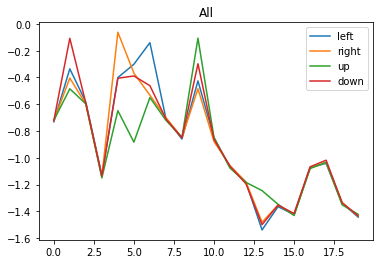

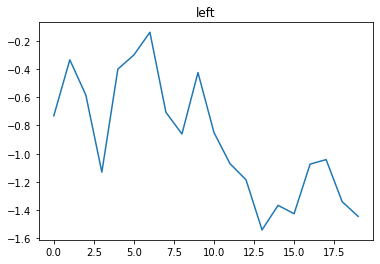

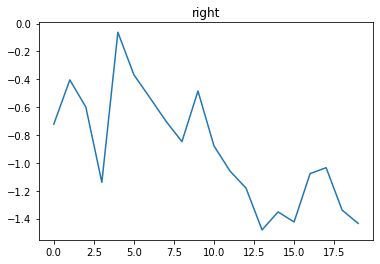

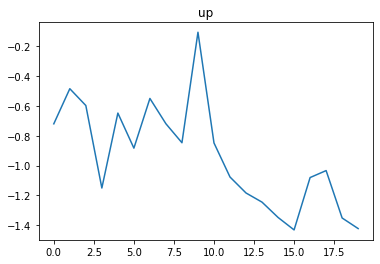

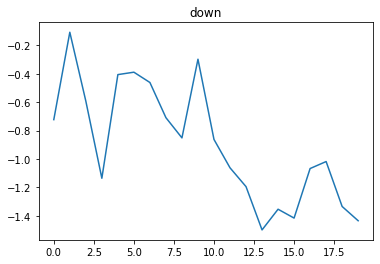

In [28]:
data = []

# Test each state for its Q-value in each action
for action in action_set:
    data += [choice_function(model.predict(encode(state, action))+bias) for state in range(maze_size)]

# Format for showing all on one graph
data = np.reshape(data, [len(action_set),maze_size]).T

plt.plot(data)
plt.title("All")
plt.legend(action_set)
plt.show()

data = data.T

i = 0
for a in data:
    plt.plot(a)
    plt.title(action_set[i])
    plt.show()
    i += 1
window_size = 100
#data = [np.mean(suboptimal_steps[x:x+window_size]) for x in range(len(suboptimal_steps)-window_size)]
#plt.plot(data)
#plt.show()